In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms

<ipython-input-1-43f329d4a96e>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda')

True
Tesla T4


## Prepare the data

In [ ]:
unzipped_data_file_name = 'trafic_32'
zipped_data_file_name = f'{unzipped_data_file_name}.zip'

(Optional) load from Google Drive

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    data_zip_path = f'/content/drive/My Drive/ssne/{zipped_data_file_name}'

    print('Successfully loaded from Google Drive')

except Exception:

    data_zip_path = zipped_data_file_name

    print('Failed to load from Google Drive')

Mounted at /content/drive
Successfully loaded from Google Drive


Unzip

In [ ]:
import os
import zipfile

if not os.path.exists(unzipped_data_file_name):
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(
    root=unzipped_data_file_name,
    transform=transform
)

class_count = len(dataset.classes)

train_split = 0.8
val_split = 0.1

batch_size = 128
drop_last = False

train_dataset_size = int(train_split * len(dataset))
val_dataset_size = int(val_split * len(dataset))
test_dataset_size = len(dataset) - train_dataset_size - val_dataset_size

train_dataset, val_dataset, test_dataset = data.random_split(
    dataset,
    [train_dataset_size, val_dataset_size, test_dataset_size]
)

def create_dloader(
    dataset: data.Dataset,
    batch_size: int,
    shuffle: bool,
    drop_last: bool,
    pin_memory: bool
) -> tuple[data.DataLoader, int]:

    sample_count: int
    if drop_last:
        sample_count = len(dataset) - len(dataset) % batch_size
    else:
        sample_count = len(dataset)

    dloader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        pin_memory=pin_memory,
        num_workers=2
    )

    return (dloader, sample_count)

train_dloader, train_sample_count = create_dloader(train_dataset, batch_size, shuffle=True, drop_last=True, pin_memory=True)
print(f'Train sample count: {train_sample_count}')

val_dloader, val_sample_count = create_dloader(val_dataset, batch_size, shuffle=True, drop_last=True, pin_memory=True)
print(f'Validation sample count: {val_sample_count}')

test_dloader, test_sample_count = create_dloader(test_dataset, batch_size, shuffle=False, drop_last=False, pin_memory=False)
print(f'Test sample count: {test_sample_count}')

Train sample count: 31360
Validation sample count: 3840
Test sample count: 3922


# VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int, class_conditioning_dim: int):
        super().__init__()

        self.conv_1 = nn.Conv2d(3 + class_conditioning_dim, 64, kernel_size=3, stride=2, padding=1)
        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.fc_1 = nn.Linear(256 * 4 * 4, 2048)
        self.fc_2 = nn.Linear(2048, 1024)

        init.xavier_normal_(self.conv_1.weight)
        init.xavier_normal_(self.conv_2.weight)
        init.xavier_normal_(self.conv_3.weight)

        init.xavier_normal_(self.fc_1.weight)
        init.xavier_normal_(self.fc_2.weight)

        self.model = nn.Sequential(
            self.conv_1,
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            self.conv_2,
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            self.conv_3,
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(start_dim=1),

            self.fc_1,
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2, inplace=True),

            self.fc_2,
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_log_var = nn.Linear(1024, latent_dim)

        init.xavier_normal_(self.fc_mean.weight)
        init.xavier_normal_(self.fc_log_var.weight)


    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 32, 32)
        x = torch.cat([x, labels], 1)
        x = self.model(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)

        return mean, log_var


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int, class_conditioning_dim: int):
        super().__init__()

        self.fc_1 = nn.Linear(latent_dim + class_conditioning_dim, 1024)
        self.fc_2 = nn.Linear(1024, 2048)
        self.fc_3 = nn.Linear(2048, 256 * 4 * 4)

        init.xavier_normal_(self.fc_1.weight)
        init.xavier_normal_(self.fc_2.weight)
        init.xavier_normal_(self.fc_3.weight)

        self.linears = nn.Sequential(
            self.fc_1,
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            self.fc_2,
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2, inplace=True),

            self.fc_3,
            nn.BatchNorm1d(256 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.ct_1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.ct_2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.ct_3 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        init.xavier_normal_(self.ct_1.weight)
        init.xavier_normal_(self.ct_2.weight)
        init.xavier_normal_(self.ct_3.weight)

        self.conv_trans = nn.Sequential(
            self.ct_1,
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            self.ct_2,
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            self.ct_3,
            nn.Tanh()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], 1)
        x = self.linears(x)
        x = x.view(-1, 256, 4, 4)
        x = self.conv_trans(x)

        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim: int, class_conditioning_dim: int):
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim, class_conditioning_dim)
        self.decoder = Decoder(latent_dim, class_conditioning_dim)

    def reparameterization(self, mean, log_var):
        std_dev = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std_dev)

        return mean + epsilon * std_dev

    def forward(self, x, labels):
        mean, log_var = self.encoder(x, labels)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decoder(z, labels)

        return x_hat, mean, log_var

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
vae = VAE(256, class_count).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

criterion = vae_loss_function

In [13]:
num_epochs = 250

for n in range(num_epochs):

    losses_epoch = []
    for x, labels in train_dloader:
        x = x.to(device)
        labels = F.one_hot(labels, class_count).type(torch.float).to(device)

        output, mean, log_var = vae(x, labels)
        loss = criterion(x, output, mean, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    L1_list = []
    for x, labels in test_dloader:
        x = x.to(device)
        labels = F.one_hot(labels, class_count).type(torch.float).to(device)

        output, _, _ = vae(x, labels)
        L1_list.append(torch.mean(torch.abs(output - x)).item())

    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch)):.2f}, test L1 = {np.mean(L1_list):.6f}")
    # scheduler.step()

Epoch 0 loss 21383.99, test L1 = 0.141100
Epoch 1 loss 20515.86, test L1 = 0.135661
Epoch 2 loss 19787.53, test L1 = 0.134471
Epoch 3 loss 19166.06, test L1 = 0.136922
Epoch 4 loss 18843.76, test L1 = 0.129156
Epoch 5 loss 18230.66, test L1 = 0.128725
Epoch 6 loss 17839.22, test L1 = 0.126036
Epoch 7 loss 17648.92, test L1 = 0.126627
Epoch 8 loss 17265.02, test L1 = 0.125394
Epoch 9 loss 17020.76, test L1 = 0.122304
Epoch 10 loss 16771.52, test L1 = 0.122088
Epoch 11 loss 16632.06, test L1 = 0.124964
Epoch 12 loss 16257.75, test L1 = 0.120726
Epoch 13 loss 16173.06, test L1 = 0.118894
Epoch 14 loss 16042.78, test L1 = 0.117972
Epoch 15 loss 15716.15, test L1 = 0.118832
Epoch 16 loss 15562.68, test L1 = 0.118384
Epoch 17 loss 15431.70, test L1 = 0.116452
Epoch 18 loss 15131.39, test L1 = 0.115407
Epoch 19 loss 14991.67, test L1 = 0.113974
Epoch 20 loss 14899.39, test L1 = 0.113528
Epoch 21 loss 14665.36, test L1 = 0.116314
Epoch 22 loss 14743.99, test L1 = 0.116226
Epoch 23 loss 14578.6

In [14]:
torch.save(vae, 'model.pth')

In [ ]:
def load_model(path):
    model_path = f'/content/drive/My Drive/ssne/{path}'
    model = torch.load(model_path, map_location=torch.device('cuda'))
    return model

In [ ]:
# vae = load_model('model.pth')

In [16]:
def visualize_reconstructions(vae_model, input_imgs, labels, device):
    # Reconstruct images
    print(type(vae_model))
    vae_model.eval()
    with torch.no_grad():
        labels = F.one_hot(labels, class_count).type(torch.float).to(device)
        reconst_imgs, mean, log_var = vae_model(input_imgs.to(device), labels)
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)

    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    grid = (grid + 1) / 2
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [17]:
def get_val_images(num):
    data = [val_dataset[i] for i in range(10, 10 + num)]

    imgs = torch.stack([sample[0] for sample in data], dim=0)
    labels = torch.stack([torch.tensor([sample[1]]) for sample in data], dim=0).squeeze()

    return imgs, labels

<class '__main__.VAE'>


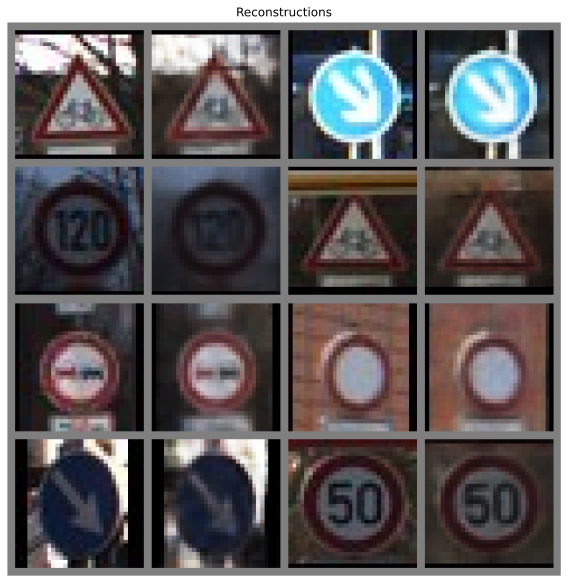

In [18]:
def get_train_images(num):
    data = [test_dataset[i] for i in range(10, 10 + num)]

    imgs = torch.stack([sample[0] for sample in data], dim=0)
    labels = torch.stack([torch.tensor([sample[1]]) for sample in data], dim=0).squeeze()

    return imgs, labels

input_imgs, labels = get_train_images(8)
visualize_reconstructions(vae, input_imgs, labels, device)

In [19]:
def generate_images(model, n_imgs, device):
  model.eval()
  with torch.no_grad():
      noise = torch.randn([n_imgs, model.latent_dim]).to(device)
      labels = torch.randint(0, class_count, (n_imgs,)).to(device)
      labels = F.one_hot(labels, class_count).type(torch.float).to(device)

      generated_imgs = model.decoder(noise, labels)
  generated_imgs = generated_imgs.cpu()
  return generated_imgs

In [34]:
def show_images(model, n_imgs, device):
    generated_imgs = generate_images(model, n_imgs, device)

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

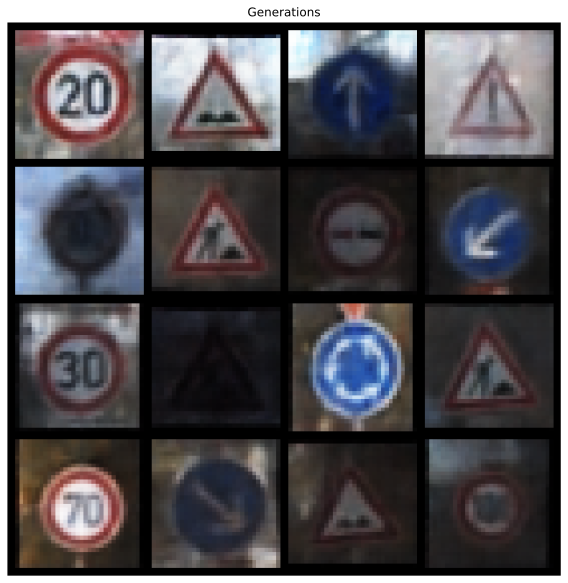

In [35]:
show_images(vae, 16, device)





#  Fréchet Inception Distance

In [22]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid
def calculate_activation_statistics(
    images, model, batch_size=50, dims=2048, device="cpu", num_workers=1, cuda=False
):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    model.eval()
    act=np.empty((len(images), dims))

    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)
    # print(pred.size())
    pred = pred[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    # if pred.size(2) != 1 or pred.size(3) != 1:
    #     pred = torch.nn.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [23]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [24]:
def calculate_fretchet(images_real,images_fake,model):

     resized_images = F.interpolate(images_real, size=(129, 129), mode='bilinear', align_corners=False)
     resized_fake = F.interpolate(images_fake, size=(129, 129), mode='bilinear', align_corners=False)

     resized_images = resized_images.to(device)
     resized_fake = resized_fake.to(device)
    #  print(resized_images.size())

     mu_1,std_1=calculate_activation_statistics(resized_images,model,cuda=False)
     mu_2,std_2=calculate_activation_statistics(resized_fake,model,cuda=False)

     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [25]:
def denormalize(tensor):
    return (tensor * 0.5 + 0.5) * 255

In [26]:
fake_imgs = denormalize(generate_images(vae, 1000, device))
input_imgs, labels = get_val_images(1000)
input_imgs = denormalize(input_imgs)


In [27]:
from torchvision.models import inception_v3

model = inception_v3(pretrained=True, transform_input=False).to('cuda')
model.fc = torch.nn.Identity()
model.aux_logits = False
model=model.cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 160MB/s] 


In [28]:
print(f"FD VAE: {calculate_fretchet(input_imgs, fake_imgs, model)}")

FD VAE: 16.2577127857951


# Zapisz do folderu

In [29]:
torch.save(fake_imgs.cpu().detach(),"piątek_Kubiszyn_Sobiech.pt")

In [30]:
import torch
from PIL import Image
import os

def save_image(tensor, filename):
    image = Image.fromarray(tensor.permute(1, 2, 0).cpu().numpy().astype('uint8'))
    image.save(filename)

def save_images_to_folder(tensors, folder_path):

    # Tworzy folder, jeśli nie istnieje
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Iteruje przez wszystkie tensory i zapisuje je jako obrazy
    for i, tensor in enumerate(tensors):
        filename = os.path.join(folder_path, f'image_{i+1}.png')
        save_image(tensor, filename)


In [31]:
save_images_to_folder(fake_imgs, 'wygenerowane_obrazy/')

In [32]:
!zip -r /content/wygenerowane_obrazy.zip /content/wygenerowane_obrazy/

  adding: content/wygenerowane_obrazy/ (stored 0%)
  adding: content/wygenerowane_obrazy/image_124.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_975.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_230.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_43.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_359.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_808.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_207.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_765.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_674.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_600.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_415.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_457.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_840.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_979.png (stored 0%)
  adding: content/wygenerowane_obrazy/image_913.png (s

In [33]:
from google.colab import files
files.download("/content/wygenerowane_obrazy.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>